In [1]:
import numpy as np
import re
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [2]:
nltk.data.path.append("/kaggle/input/nltk-data/nltk-data")

In [3]:
train_essays_df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
display(train_essays_df)

train_essays_df['generated'].value_counts()

train_essays_df[train_essays_df['generated']==1]

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [4]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation
print(stop_words)
print(punctuations)

{'go', 'two', 'whereby', 'however', 'due', 'we', 'anyone', 'perhaps', 'twelve', '’ll', 'latter', 'me', "'m", 'anywhere', 'part', 'hereafter', 'our', 'various', 'mostly', 'using', 'should', 'formerly', 'somehow', 'amongst', 'of', "'re", "'ll", 'from', 'became', 'neither', 'only', 'serious', 'thereupon', 'is', 'could', 'has', 'in', 'him', 'my', 'others', 'myself', 'how', 'with', 'per', 'were', 'alone', 'one', 'something', 'more', 'might', 'can', 'everything', 'himself', 'both', 'eleven', 'this', 'hundred', 'at', 'former', 'none', 'behind', '‘ve', 'their', 'still', 'someone', 'its', 'together', 'yourselves', 'then', 'please', 'be', 'what', 'those', 'front', 'along', 'across', 'by', 'whatever', 'through', 'already', 'below', '‘re', 'i', 'hereby', 'n‘t', 'ours', 'thereafter', 'within', 'meanwhile', 'whereas', 'really', 'on', 'though', 'three', 'back', 'must', 'thus', 'as', 'these', 'ourselves', 'itself', 'anything', 'become', 'hereupon', 'once', 'when', 'either', 'almost', 'may', 'towards',

In [5]:
def clean_text(text):
    doc = nlp(text.lower().strip())
    tokens = [word.lemma_ for word in doc if word.text not in stop_words and word.text not in punctuations]
    return " ".join(tokens)

In [6]:
train_essays_df['cleaned_text'] = train_essays_df['text'].apply(clean_text)

In [7]:
X = train_essays_df['cleaned_text']
y = train_essays_df['generated']
tfidf = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

In [8]:
X_tfidf_shuffled, y_shuffled = shuffle(X_tfidf, y, random_state=42)

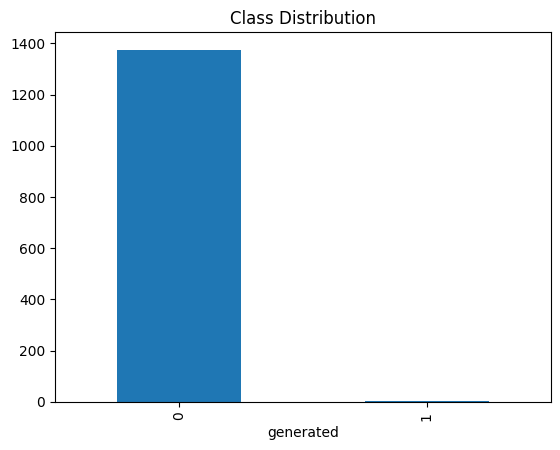

In [9]:
train_essays_df['generated'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

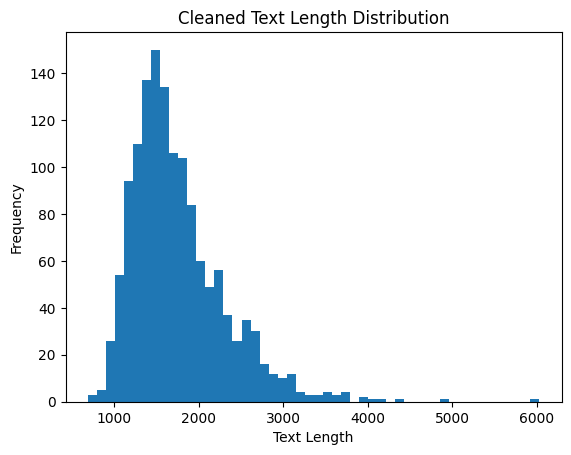

In [10]:
train_essays_df['cleaned_text'].apply(len).plot(kind='hist', bins=50, title='Cleaned Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
model = SVC(probability=True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(model, parameters, cv=5)

# Fit and Tune Model
clf.fit(X_tfidf_shuffled, y_shuffled)
print("Best Parameters:", clf.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'C': 1, 'kernel': 'linear'}


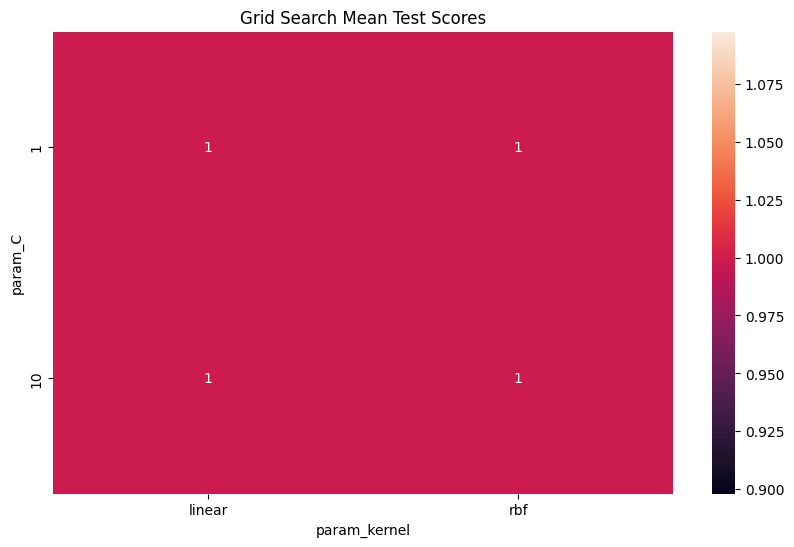

In [12]:
cv_results = pd.DataFrame(clf.cv_results_)
plt.figure(figsize=(10, 6))
sns.heatmap(pd.pivot_table(cv_results, values='mean_test_score', index='param_C', columns='param_kernel'), annot=True)
plt.title('Grid Search Mean Test Scores')
plt.show()

In [13]:
skf = StratifiedKFold(n_splits=5)
accuracies = []
for train_index, test_index in skf.split(X_tfidf_shuffled, y_shuffled):
    X_train, X_test = X_tfidf_shuffled[train_index], X_tfidf_shuffled[test_index]
    y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

    model.set_params(**clf.best_params_)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

print("Average accuracy:", np.mean(accuracies))

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Average accuracy: 0.9978260869565216


In [14]:
test_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_tfidf = tfidf.transform(test_df['cleaned_text'])

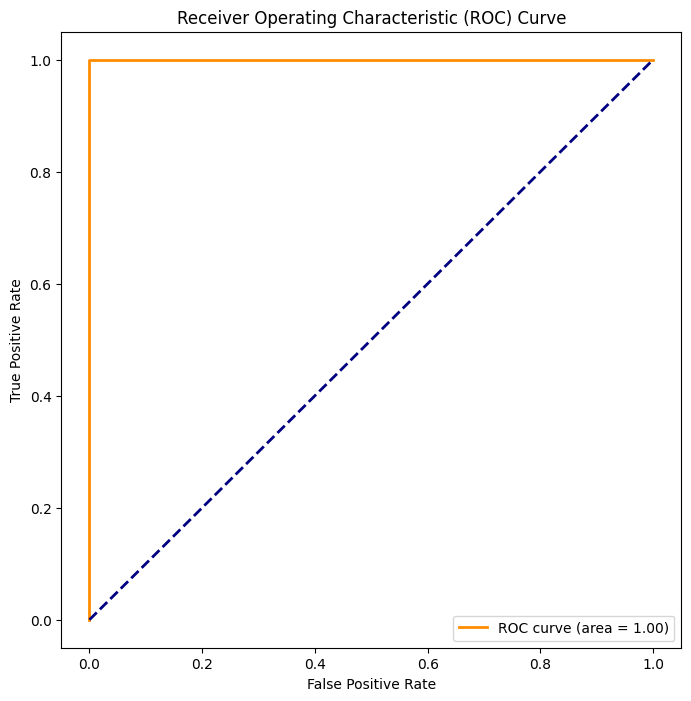

In [15]:
y_probs = model.predict_proba(X_tfidf_shuffled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_shuffled, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
submit = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
submit['generated'] = model.predict_proba(test_tfidf)[:,1]

submit.to_csv('submission.csv', index=False)

In [17]:
submit.head()

,id,generated
0,0000aaaa,0.010518
1,1111bbbb,0.010518
2,2222cccc,0.010518
